In [1]:
%pip install tqdm
%pip install numpy
%pip install pandas
%pip install gymnasium
%pip install torch
%pip install matplotlib
%pip install seaborn
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!nvidia-smi

Thu Nov 28 23:21:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 2000 Ada Gene...    On  |   00000000:C3:00.0 Off |                  Off |
| 30%   24C    P8              7W /   70W |       2MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tools.scopa_env import *
from tools.scopone_scientifico_sim import *
import numpy as np
import pandas as pd
import seaborn as sns

import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

print(f'Playing on {device}')

Playing on cuda


In [5]:
env = ScopaEnv()

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        print(f'Creating DQN with {n_observations} observations and {n_actions} actions')
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        return self.layer3(x)

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = 40
# Get the number of state observations
state = env.reset()
state = state.flatten()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(torch.load('/workspace/ScopaAI_ToM/train/exp_2024-11-28 22:55:43.016146_15000.pth'))

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)


steps_done = 0


def select_action(state, player):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    pred = []
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            pred = policy_net(state.flatten()).detach().cpu().numpy()
    else:
        pred = env.action_space.sample()[0]

    map = [env.game.map_card_index(card) for card in player.hand]

    
    actionset = pd.DataFrame(np.array(pred))
    actionset = actionset.sort_values(by=0, ascending=True)
    actionset = actionset[actionset.index.isin(map)]

    return actionset

    


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Commulative Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Creating DQN with 120 observations and 40 actions
Creating DQN with 120 observations and 40 actions


/tmp/ipykernel_10974/964632192.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_net.load_state_dict(torch.load('/workspace/ScopaAI_ToM/train/exp_2024-11-28 22:55:

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    #print(f'state_batch: {state_batch.shape}, action_batch: {action_batch.shape}, reward_batch: {reward_batch.shape}')

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE,n_actions, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.unsqueeze(1)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Episodes:   0%|          | 0/15000 [00:00<?, ?it/s]

Episodes: 100%|██████████| 15000/15000 [42:10<00:00,  5.93it/s] 


Complete


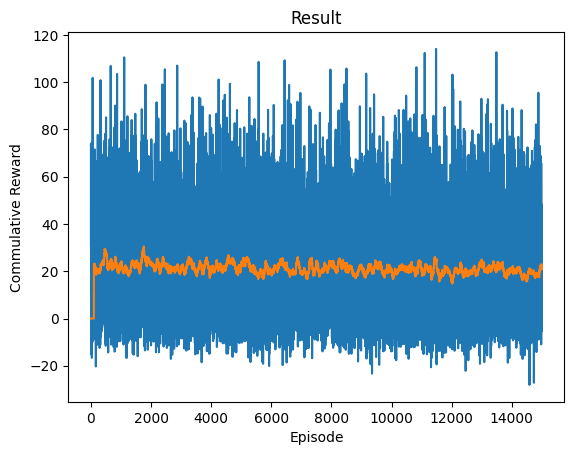

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available():
    num_episodes = 15000
else:
    num_episodes = 10

scores = []

for i_episode in tqdm(range(num_episodes), desc='Episodes'):
    # Initialize the environment and get its state
    state = env.reset()
    player = env.player
    done = False
    #print(F'Player {player.__hash__()}')
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    commulative_reward = 0
    
    for t in count():
        action = select_action(state, player)
        selected_action = None
        for i in range(0,len(action.index)):
            if env.action_valid(action.index[i], player):
                selected_action = action.index[i]
                break
            
        if selected_action is None:
            raise Exception(f'No valid action found. {action} | {[env.game.map_card_index(card) for card in player.hand]}')
        observation, reward, done, _ = env.step(selected_action, player=player, v=-6)#v=-7 for each game update!
        #print(f'state{state} action {action} observation {observation.shape} reward{reward} terminated{done}')
        commulative_reward += reward
        reward = torch.tensor([reward], device=device)
        
        if done:
            scores.append(env.game.match_points)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


        # Store the transition in memory
        memory.push(state, torch.tensor(action.index, dtype=torch.int64, device=device), next_state if next_state is not None else None, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(commulative_reward)
            break

torch.save(policy_net.state_dict(), f'/workspace/ScopaAI_ToM/train/exp_{datetime.datetime.now()}_{num_episodes}.pth')

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

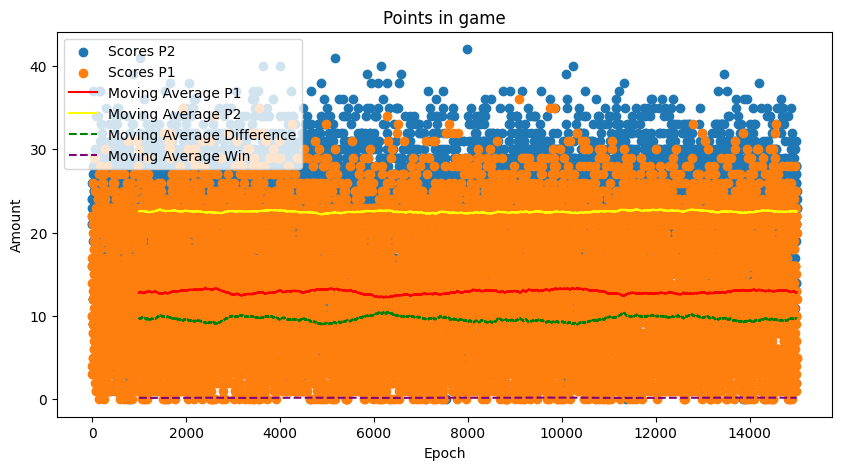

In [ ]:
# Convert the scores list to a numpy array for easier manipulation
scores_array = np.array(scores)

# Calculate the difference of scores
score_diff = scores_array[:, 0] - scores_array[:, 1]

# Calculate the moving average
window_size = 1000
moving_avg_p1 = np.convolve(scores_array[:, 0], np.ones(window_size)/window_size, mode='valid')
moving_avg_p2 = np.convolve(scores_array[:, 1], np.ones(window_size)/window_size, mode='valid')
moving_avg_d = np.convolve(scores_array[:, 1]-scores_array[:, 0], np.ones(window_size)/window_size, mode='valid')

# Plot the scores and the moving average trendlines
plt.figure(figsize=(10, 5))
plt.scatter(range(len(scores_array[:, 1])), scores_array[:, 1], label='Scores P2')
plt.scatter(range(len(scores_array[:, 0])), scores_array[:, 0], label='Scores P1')
plt.plot(range(window_size-1, len(scores_array[:, 0])), moving_avg_p1, label='Moving Average P1', linestyle='-', color='red')
plt.plot(range(window_size-1, len(scores_array[:, 1])), moving_avg_p2, label='Moving Average P2', linestyle='-', color='yellow')
plt.plot(range(window_size-1, len(scores_array[:, 1])), moving_avg_d, label='Moving Average Difference', linestyle='--', color='green')
plt.xlabel('Epoch')
plt.ylabel('Amount')
plt.title('Points in game')
plt.legend()
plt.show()


#todo in the future. The agent is learning but playing with a random agent does nto help. I need to figure out how to 

In [13]:
scores_array

array([[ 3, 24],
       [10, 24],
       [22, 16],
       ...,
       [ 5, 23],
       [12, 25],
       [20, 24]])

In [14]:
scores_decom = pd.DataFrame(scores_array, columns=['S1', 'S2'])
scores_decom['Diff'] = scores_decom['S1'] <= scores_decom['S2']

In [38]:
print(scores_decom['Diff'])

0         True
1         True
2        False
3         True
4         True
         ...  
14995     True
14996     True
14997     True
14998     True
14999     True
Name: Diff, Length: 15000, dtype: bool


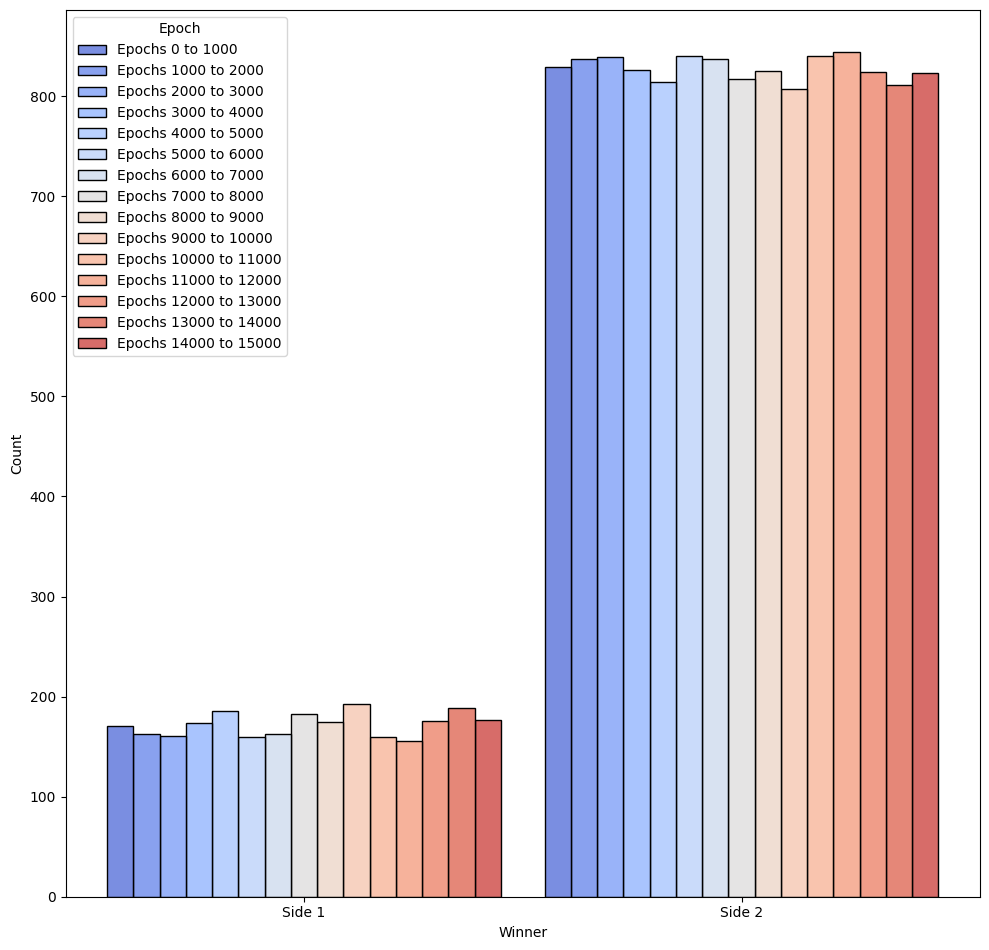

In [85]:
plt.figure(figsize=(10, 10))

epochs_per_range = len(scores_decom) // 15

ep = ['' for _ in range(len(scores_decom))]

for i in range(15):
    start = i * epochs_per_range
    end = (i + 1) * epochs_per_range
    ep[start:end] = [f'Epochs {start} to {end}' for _ in range(epochs_per_range)]

scores_decom['Epoch'] = ep

sns.histplot(x='Diff', hue='Epoch', data=scores_decom, multiple='dodge', discrete=True,palette='coolwarm', shrink=0.9)
plt.xticks([0, 1], ['Side 1', 'Side 2'])
plt.xlabel('Winner')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()